In [9]:
from __future__ import annotations

import argparse
import csv
import time
from pathlib import Path
from statistics import mean, stdev
from typing import Generator, Tuple

import clingo
import matplotlib.pyplot as plt
import pandas as pd
import secrets
import generator

def run_clingo(h: int, w: int, d: int, program: Path) -> float:
    seed = secrets.randbelow(2**31)
    start = time.perf_counter()
    ctl = clingo.Control(["-c", f"height={h}", "-c", f"width={w}", "-c", f"depth={d}", "--rand-freq=0.5", "-t 11", f"--seed={str(seed)}"])
    ctl.load(str(program))
    ctl.ground([("base", [])])
    ctl.solve()
    return time.perf_counter() - start

def run_gen1(height, width, depth):
    return run_clingo(height, width, depth, Path("generator.lp"))

def run_gen2(h: int, w: int, d: int) -> float:
    start = time.perf_counter()
    generator.run_generator(h, w, d)
    return time.perf_counter() - start

def run_solver() -> float:
    start = time.perf_counter()
    generator.run_solver()
    return time.perf_counter() - start

def run_solver_without_pipes() -> float:
    start = time.perf_counter()
    generator.run_solver_without_pipes()
    return time.perf_counter() - start

def init_csv(path: Path):
    with path.open("w", newline="") as fh:
        csv.writer(fh).writerow(["height", "width", "depth", "run", "seconds", "size"])

def append_csv(path: Path, h: int, w: int, d: int, run_idx: int, seconds: float):
    with path.open("a", newline="") as fh:
        csv.writer(fh).writerow([h, w, d, run_idx, f"{seconds:.6f}", h * w * d])

def aggregate(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    grp = df.groupby("size").agg(mean_seconds=("seconds", mean), std_seconds=("seconds", stdev)).reset_index()
    grp.sort_values("size", inplace=True)
    return grp

def plot_size_vs_time(df: pd.DataFrame, out_svg: Path | None, logscale=True):
    fig, ax = plt.subplots()
    ax.plot(df["size"], df["mean_seconds"], 'o-')

    for _, row in df.iterrows():
        x = float(row["size"])
        y = float(row["mean_seconds"])
        ax.annotate(
            f"{int(row['size'])}",
            xy=(x, y),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

    ax.set_xlabel("Problem size (H × W × D)")
    if logscale:
        ax.set_ylabel("Mean runtime (s, log‑scale)")
        ax.set_yscale("log")
    else:
        ax.set_ylabel("Mean runtime (s)")
    # ax.set_title("Clingo runtime vs. problem size")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)
    fig.tight_layout()
    if out_svg:
        fig.savefig(out_svg, format="svg")
        print(f"Saved plot to {out_svg}")

    plt.show()

def plot_multiple(dfs, labels, out_svg: Path | None, logscale=True, colors=None):
    fig, ax = plt.subplots()

    for i, df in enumerate(dfs):
        if colors is not None:
            ax.plot(df["size"], df["mean_seconds"], 'o-', label=labels[i], color=colors[i])
        else:
            ax.plot(df["size"], df["mean_seconds"], 'o-', label=labels[i])

    for _, row in dfs[0].iterrows():
        x = float(row["size"])
        y = float(row["mean_seconds"])
        ax.annotate(
            f"{int(row['size'])}",
            xy=(x, y),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

    ax.set_xlabel("Problem size (H × W × D)")
    if logscale:
        ax.set_ylabel("Mean runtime (s, log‑scale)")
        ax.set_yscale("log")
    else:
        ax.set_ylabel("Mean runtime (s)")
    # ax.set_title("Clingo runtime vs. problem size")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)
    ax.legend()
    fig.tight_layout()
    if out_svg:
        fig.savefig(out_svg, format="svg")
        print(f"Saved plot to {out_svg}")

    plt.show()

def run(sizes, csv, gen, solvers=None, n=10):
    total_runs = len(sizes) * n

    current = 0
    for h, w, d, _ in sizes:
        for run_idx in range(1, n + 1):
            current += 1

            print("\r", end="", flush=True)

            print(f"[{current}/{total_runs}] h={h} w={w} d={d} run={run_idx} …", end="", flush=True)

            secs = gen(h, w, d)

            append_csv(csv, h, w, d, run_idx, secs)
            print(f" {secs:.3f}s", end=" ")

            for solver, solver_csv in solvers:
                if solver is not None:
                    secs = solver()
                    append_csv(solver_csv, h, w, d, run_idx, secs)
                    print(f"solve={secs:.3f}s", end=" ")

            print()
    

In [8]:
generator.run_generator(3, 3, 3, print=False)
print("Generator finished")
generator.run_solver(print=True)

Generator finished
block_pos(2,2,1,4,1).
block_pos(2,3,1,5,1).
block_pos(1,2,2,1,1).
block_pos(3,2,2,2,1).
block_pos(2,2,3,3,1).
block_pos(1,3,1,5,4).
block_pos(2,1,1,4,3).
block_pos(3,2,3,3,2).
block_pos(2,3,3,3,5).
block_pos(1,2,3,3,4).
block_pos(3,1,2,2,4).
block_pos(3,2,1,2,2).
block_pos(2,2,2,1,2).
block_pos(2,3,2,1,3).
block_pos(3,3,1,2,3).
block_pos(3,3,3,3,6).
block_pos(3,1,1,4,2).
block_pos(2,1,2,4,6).
block_pos(1,2,1,5,6).
block_pos(1,3,2,5,7).
block_pos(1,3,3,5,3).
block_pos(1,1,1,5,5).
block_pos(2,1,3,4,5).
block_pos(3,3,2,3,3).
block_pos(3,1,3,4,4).
block_pos(1,1,2,5,8).
block_pos(1,1,3,5,2).
pipe_pos(2,1,2,e,w).
pipe_pos(2,3,3,e,w).
pipe_pos(2,3,1,e,b).
pipe_pos(2,2,2,e,a).
pipe_pos(2,2,1,e,a).
pipe_pos(1,1,2,e,n).
pipe_pos(1,3,3,e,s).
pipe_pos(1,2,3,e,s).
pipe_pos(1,1,3,e,s).
pipe_pos(2,3,1,b,e).
pipe_pos(2,2,3,b,w).
pipe_pos(3,2,2,b,w).
pipe_pos(3,2,1,b,w).
pipe_pos(2,3,2,b,a).
pipe_pos(1,3,1,b,n).
pipe_pos(2,1,2,w,e).
pipe_pos(2,3,3,w,e).
pipe_pos(2,2,3,w,b).
pipe_pos(

In [2]:
CSV_GEN1 = Path("results/gen1.csv") # Gen1 = without #programs
CSV_GEN2 = Path("results/gen2.csv") # Gen2 = with #programs
CSV_SOLVER = Path("results/solver.csv")
CSV_SOLVER_WITHOUT_PIPES = Path("results/solver_without_pipes.csv")

SVG_GEN1 = Path("results/gen1.svg")
SVG_GEN2 = Path("results/gen2.svg")
SVG_SOLVER = Path("results/solver.svg")
SVG_SOLVER_WITHOUT_PIPES = Path("results/solver_without_pipes.svg")

In [10]:
# init_csv(CSV_GEN1)
init_csv(CSV_GEN2)
init_csv(CSV_SOLVER)
init_csv(CSV_SOLVER_WITHOUT_PIPES)

In [11]:
sizes = []

for i in range(2, 7):
    for j in range(2, 7):
        for h in range(2, 7):
            if i <= j <= h:
                sizes.append((i, j, h, i*j*h))

sizes.sort(key=lambda x: x[3])
print(sizes)

[(2, 2, 2, 8), (2, 2, 3, 12), (2, 2, 4, 16), (2, 3, 3, 18), (2, 2, 5, 20), (2, 2, 6, 24), (2, 3, 4, 24), (3, 3, 3, 27), (2, 3, 5, 30), (2, 4, 4, 32), (2, 3, 6, 36), (3, 3, 4, 36), (2, 4, 5, 40), (3, 3, 5, 45), (2, 4, 6, 48), (3, 4, 4, 48), (2, 5, 5, 50), (3, 3, 6, 54), (2, 5, 6, 60), (3, 4, 5, 60), (4, 4, 4, 64), (2, 6, 6, 72), (3, 4, 6, 72), (3, 5, 5, 75), (4, 4, 5, 80), (3, 5, 6, 90), (4, 4, 6, 96), (4, 5, 5, 100), (3, 6, 6, 108), (4, 5, 6, 120), (5, 5, 5, 125), (4, 6, 6, 144), (5, 5, 6, 150), (5, 6, 6, 180), (6, 6, 6, 216)]


In [ ]:
# Run Gen1
# TODO: Show the difference with and without --rand-freq in the slides 
# run(sizes[0:5], CSV_GEN1, run_gen1, n=10)

[1/50] h=2 w=2 d=2 run=1 … 0.151s
[2/50] h=2 w=2 d=2 run=2 … 0.122s
[3/50] h=2 w=2 d=2 run=3 … 0.151s
[4/50] h=2 w=2 d=2 run=4 … 0.129s
[5/50] h=2 w=2 d=2 run=5 … 0.127s
[6/50] h=2 w=2 d=2 run=6 … 0.143s
[7/50] h=2 w=2 d=2 run=7 … 0.123s
[8/50] h=2 w=2 d=2 run=8 … 0.129s
[9/50] h=2 w=2 d=2 run=9 … 0.111s
[10/50] h=2 w=2 d=2 run=10 … 0.134s
[11/50] h=2 w=2 d=3 run=1 … 0.594s
[12/50] h=2 w=2 d=3 run=2 … 0.805s
[13/50] h=2 w=2 d=3 run=3 … 0.511s
[14/50] h=2 w=2 d=3 run=4 … 0.433s
[15/50] h=2 w=2 d=3 run=5 … 0.514s
[16/50] h=2 w=2 d=3 run=6 … 0.579s
[17/50] h=2 w=2 d=3 run=7 … 0.412s
[18/50] h=2 w=2 d=3 run=8 … 0.509s
[19/50] h=2 w=2 d=3 run=9 … 0.651s
[20/50] h=2 w=2 d=3 run=10 … 0.351s
[21/50] h=2 w=2 d=4 run=1 … 2.336s
[22/50] h=2 w=2 d=4 run=2 … 1.703s
[23/50] h=2 w=2 d=4 run=3 … 1.445s
[24/50] h=2 w=2 d=4 run=4 … 1.339s
[25/50] h=2 w=2 d=4 run=5 … 1.393s
[26/50] h=2 w=2 d=4 run=6 … 1.625s
[27/50] h=2 w=2 d=4 run=7 … 3.151s
[28/50] h=2 w=2 d=4 run=8 … 1.166s
[29/50] h=2 w=2 d=4 run=9 …

In [ ]:
# run(sizes[5:7], CSV_GEN1, run_gen1, n=5)

[1/10] h=2 w=2 d=6 run=1 … 49.680s
[2/10] h=2 w=2 d=6 run=2 … 41.934s
[3/10] h=2 w=2 d=6 run=3 … 30.695s
[4/10] h=2 w=2 d=6 run=4 … 35.688s
[5/10] h=2 w=2 d=6 run=5 … 37.859s
[6/10] h=2 w=3 d=4 run=1 … 24.546s
[7/10] h=2 w=3 d=4 run=2 … 48.078s
[8/10] h=2 w=3 d=4 run=3 … 50.365s
[9/10] h=2 w=3 d=4 run=4 … 43.328s
[10/10] h=2 w=3 d=4 run=5 … 28.993s


In [ ]:
# run(sizes[7:8], CSV_GEN1, run_gen1, n=8)

[1/8] h=3 w=3 d=3 run=1 … 67.835s
[2/8] h=3 w=3 d=3 run=2 … 80.835s
[3/8] h=3 w=3 d=3 run=3 … 95.870s
[4/8] h=3 w=3 d=3 run=4 … 74.960s
[5/8] h=3 w=3 d=3 run=5 … 60.646s
[6/8] h=3 w=3 d=3 run=6 … 68.482s
[7/8] h=3 w=3 d=3 run=7 … 82.616s
[8/8] h=3 w=3 d=3 run=8 … 80.928s


In [ ]:
# run(sizes[8:11], CSV_GEN1, run_gen1, n=5)

[1/15] h=2 w=3 d=5 run=1 … 261.460s
[2/15] h=2 w=3 d=5 run=2 … 346.229s
[3/15] h=2 w=3 d=5 run=3 … 212.068s
[4/15] h=2 w=3 d=5 run=4 … 126.873s
[5/15] h=2 w=3 d=5 run=5 … 292.183s
[6/15] h=2 w=4 d=4 run=1 … 308.867s
[7/15] h=2 w=4 d=4 run=2 … 411.815s
[8/15] h=2 w=4 d=4 run=3 … 435.276s
[9/15] h=2 w=4 d=4 run=4 … 481.664s
[10/15] h=2 w=4 d=4 run=5 … 393.955s
[11/15] h=2 w=3 d=6 run=1 …

   size  mean_seconds
0     8      0.132094
1    12      0.536004
2    16      1.947090
3    18      5.590989
4    20     10.752001
5    24     39.116455
6    27     77.619589
7    30    247.762480
8    32    406.315271
Saved plot to results/gen1.svg


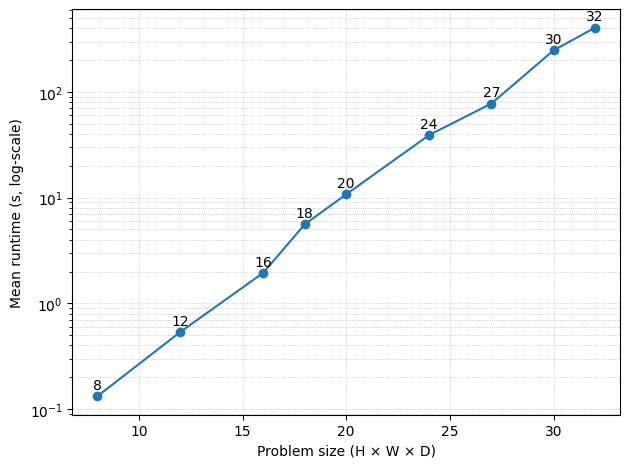

In [56]:
df = aggregate(CSV_GEN1)
print(df)
plot_size_vs_time(df, SVG_GEN1)

In [26]:
run(sizes[0:10], CSV_GEN2, run_gen2, n=10, solvers=[(run_solver, CSV_SOLVER), (run_solver_without_pipes, CSV_SOLVER_WITHOUT_PIPES)])

[1/100] h=2 w=2 d=2 run=1 … 0.055s solve=0.012s solve=0.004s 
[2/100] h=2 w=2 d=2 run=2 … 0.032s solve=0.015s solve=0.005s 
[3/100] h=2 w=2 d=2 run=3 … 0.037s solve=0.012s solve=0.004s 
[4/100] h=2 w=2 d=2 run=4 … 0.040s solve=0.019s solve=0.005s 
[5/100] h=2 w=2 d=2 run=5 … 0.034s solve=0.014s solve=0.004s 
[6/100] h=2 w=2 d=2 run=6 … 0.042s solve=0.020s solve=0.005s 
[7/100] h=2 w=2 d=2 run=7 … 0.033s solve=0.016s solve=0.004s 
[8/100] h=2 w=2 d=2 run=8 … 0.034s solve=0.018s solve=0.004s 
[9/100] h=2 w=2 d=2 run=9 … 0.030s solve=0.010s solve=0.003s 
[10/100] h=2 w=2 d=2 run=10 … 0.032s solve=0.011s solve=0.003s 
[11/100] h=2 w=2 d=3 run=1 … 0.084s solve=0.035s solve=0.006s 
[12/100] h=2 w=2 d=3 run=2 … 0.073s solve=0.036s solve=0.007s 
[13/100] h=2 w=2 d=3 run=3 … 0.083s solve=0.034s solve=0.006s 
[14/100] h=2 w=2 d=3 run=4 … 0.081s solve=0.036s solve=0.005s 
[15/100] h=2 w=2 d=3 run=5 … 0.070s solve=0.026s solve=0.006s 
[16/100] h=2 w=2 d=3 run=6 … 0.076s solve=0.025s solve=0.006s 


   size  mean_seconds
0     8      0.035179
1    12      0.082488
2    16      0.218340
3    18      0.342953
4    20      0.619957
5    24      1.630530
6    27      3.143765
7    30      4.170388
8    32      7.344445
Saved plot to results/gen2.svg


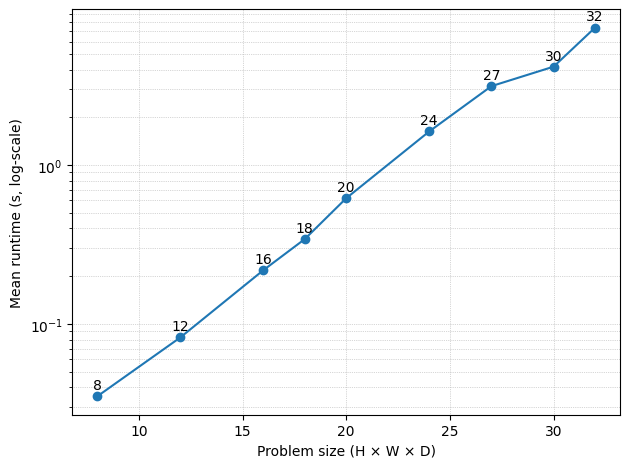

In [57]:
df = aggregate(CSV_GEN2)
print(df)
plot_size_vs_time(df, SVG_GEN2)

   size  mean_seconds
0     8      0.013104
1    12      0.033633
2    16      0.061502
3    18      0.088232
4    20      0.097098
5    24      0.207078
6    27      0.392532
7    30      0.947250
8    32      1.322809
Saved plot to results/solver.svg


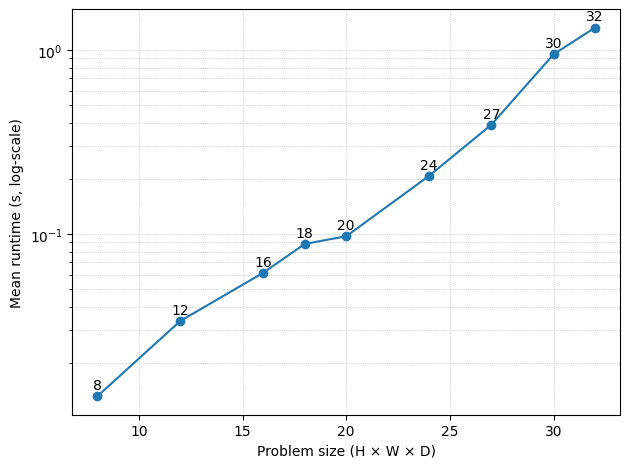

In [28]:
df = aggregate(CSV_SOLVER)
print(df)
plot_size_vs_time(df, SVG_SOLVER)

   size  mean_seconds
0     8      0.003827
1    12      0.006643
2    16      0.012303
3    18      0.013644
4    20      0.019666
5    24      0.032900
6    27      0.049374
7    30      0.057685
8    32      0.071989
Saved plot to results/solver_without_pipes.svg


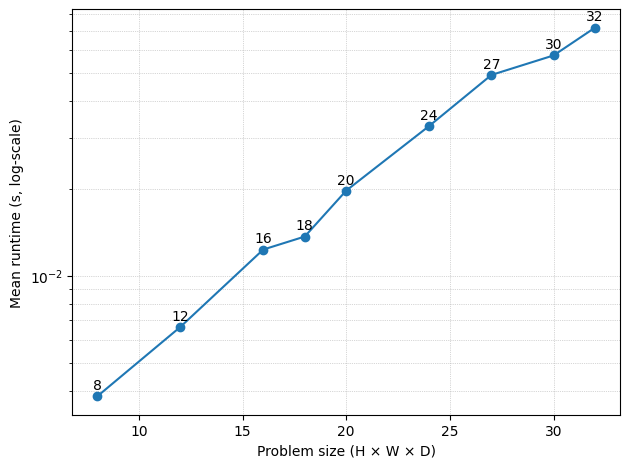

In [29]:
df = aggregate(CSV_SOLVER_WITHOUT_PIPES)
print(df)
plot_size_vs_time(df, SVG_SOLVER_WITHOUT_PIPES)

Saved plot to results/solver_both.svg


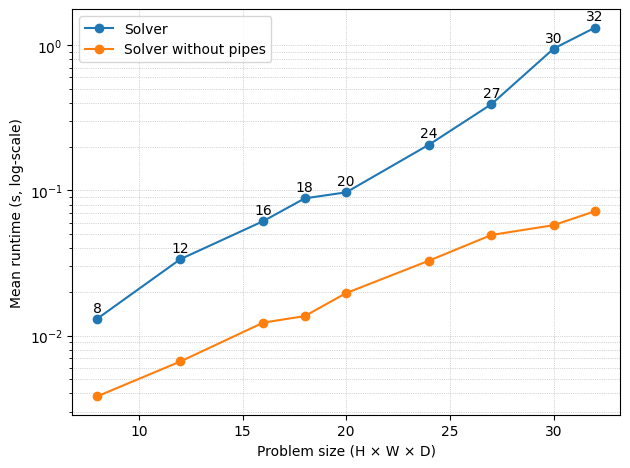

In [61]:
df = aggregate(CSV_SOLVER)

df2 = aggregate(CSV_SOLVER_WITHOUT_PIPES)
plot_multiple([df, df2], ["Solver", "Solver without pipes"], "results/solver_both.svg")

Saved plot to results/gen_both.svg


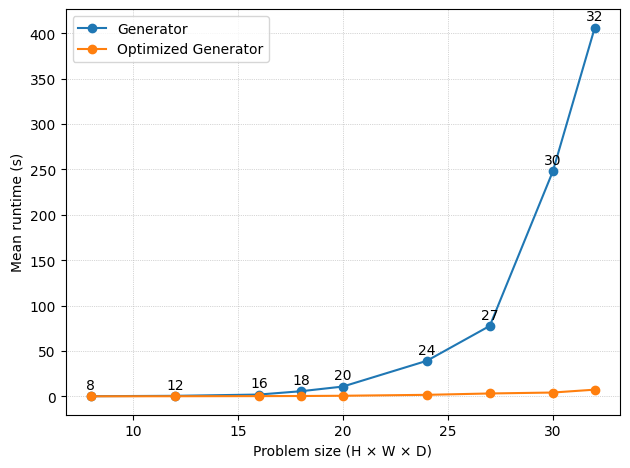

In [60]:
df = aggregate(CSV_GEN1)
df2 = aggregate(CSV_GEN2)

plot_multiple([df, df2], ["Generator", "Optimized Generator"], "results/gen_both.svg", logscale=False)

Saved plot to results/gen_both.svg


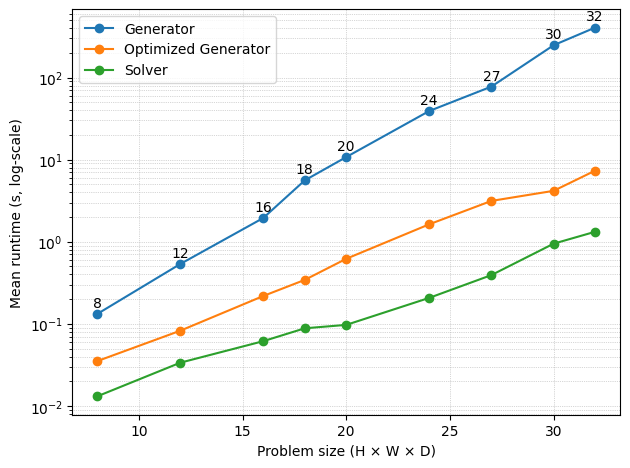

In [49]:
df = aggregate(CSV_GEN1)
df2 = aggregate(CSV_GEN2)
df3 = aggregate(CSV_SOLVER)

plot_multiple([df, df2, df3], ["Generator", "Optimized Generator", "Solver"], "results/gen_both.svg", logscale=True)

Saved plot to results/gen_both.svg


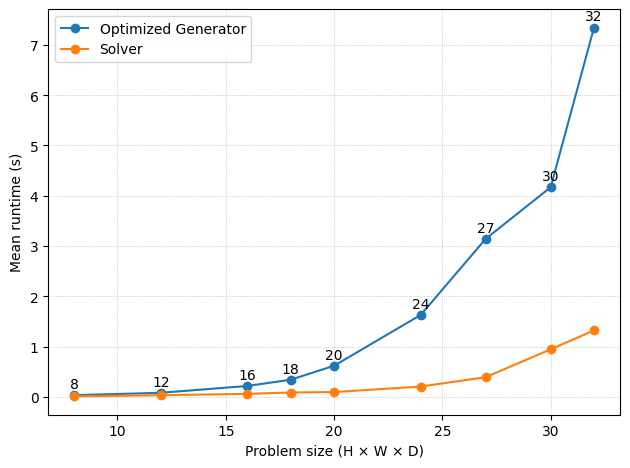

In [55]:
df2 = aggregate(CSV_GEN2)
df3 = aggregate(CSV_SOLVER)

plot_multiple([df2, df3], ["Optimized Generator", "Solver"], "results/gen_both.svg", logscale=False)

In [ ]:
df = aggregate(CSV_GEN1)
df

,size,mean_seconds,std_seconds
0,8,0.132094,0.012953
1,12,0.536004,0.130337
2,16,1.947090,0.762818
3,18,5.590989,2.078443
4,20,10.752001,2.890274
5,24,39.116455,9.086954
6,27,77.619589,14.770724
7,30,247.762480,83.284124
8,32,406.315271,63.630664


In [11]:
df = aggregate(CSV_GEN2)
df

,size,mean_seconds,std_seconds
0,8,0.035179,0.007383
1,12,0.082488,0.009356
2,16,0.218340,0.019125
3,18,0.342953,0.045771
4,20,0.619957,0.143139
5,24,1.630530,0.636415
6,27,3.143765,1.082230
7,30,4.170388,2.117283
8,32,7.344445,4.740175


In [12]:
df = aggregate(CSV_SOLVER)
df

,size,mean_seconds,std_seconds
0,8,0.013104,0.002987
1,12,0.033633,0.007890
2,16,0.061502,0.022353
3,18,0.088232,0.034800
4,20,0.097098,0.037772
5,24,0.207078,0.112256
6,27,0.392532,0.370148
7,30,0.947250,0.997411
8,32,1.322809,1.622302


In [13]:
df = aggregate(CSV_SOLVER_WITHOUT_PIPES)
df

,size,mean_seconds,std_seconds
0,8,0.003827,0.000512
1,12,0.006643,0.000849
2,16,0.012303,0.002826
3,18,0.013644,0.005318
4,20,0.019666,0.004970
5,24,0.032900,0.019173
6,27,0.049374,0.026684
7,30,0.057685,0.067867
8,32,0.071989,0.045213
